In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

import utils

In [2]:
TRAIN_TEST_SPLIT = 3000
WINDOW_SIZE = 60
BATCH_SIZE = 100
SHUFFER_BUFFER_SIZE = 1000

In [3]:
time, series = utils.load_data()

t_train, x_train = time[:TRAIN_TEST_SPLIT], series[:TRAIN_TEST_SPLIT]
t_test, x_test = time[TRAIN_TEST_SPLIT:], series[TRAIN_TEST_SPLIT:]
print(f"x_train.shape = {x_train.shape}, x_test.shape = {x_test.shape}")

x_train.shape = (3000,), x_test.shape = (235,)


In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[-1]))
    ds = ds.cache()
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [5]:
train_data = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFER_BUFFER_SIZE)
for x_batch, y_batch in train_data.take(1):
    print(x_batch.shape)
    print(y_batch.shape)

(100, 60)
(100,)


In [6]:
def build_model(lr=1e-8):
    model = keras.models.Sequential([
        keras.layers.Dense(20, input_shape=[WINDOW_SIZE], activation='relu'),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(1),
    ])

    optimizer = keras.optimizers.SGD(lr=lr, momentum=0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [7]:
keras.backend.clear_session()

model = build_model(1e-7)

history = model.fit(train_data, epochs=100, verbose=0)

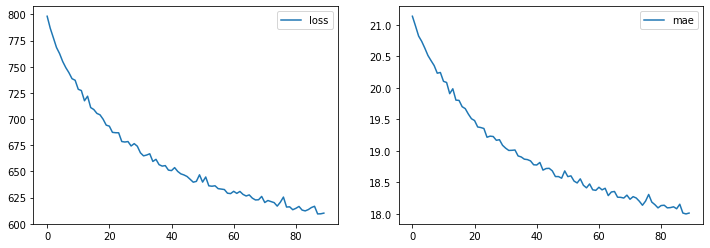

In [8]:
utils.plot_history(history, metrics=['loss', 'mae'], start=10)

mse = 442.3948, mae = 14.8961


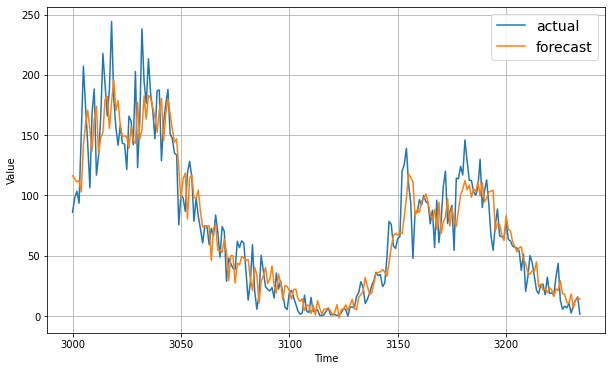

In [9]:
forecasts = []
for t in t_test:
    x = series[t-WINDOW_SIZE:t]
    forecast = model.predict(np.expand_dims(x, (0)))[0][0]
    forecasts.append(forecast)

utils.evaluate(x_test, forecasts)

utils.plot_series(t_test, [x_test, forecasts], label=['actual', 'forecast'])